**Librerías**

In [ ]:
import pandas as pd
from pyxlsb import open_workbook
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind, chi2_contingency
from pandas.api.types import is_numeric_dtype
import math
from sklearn.feature_selection import mutual_info_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

**Funciones**

In [6]:
def grafico_dispersion_2_var(df, var1, var2):
    sns.scatterplot(data=df, x=var1, y=var2, hue='default')
    plt.show()

**Carga de datos**

In [7]:
# Define la ruta al archivo .xlsb
file_path = './BBDD_Scoring.xlsb' 

# Inicializa una lista para almacenar los datos
data = []

# Lee el archivo y extrae las filas
with open_workbook(file_path) as wb:
    with wb.get_sheet(1) as sheet:  # Cambia "1" al índice correcto de la hoja si es necesario
        for row in sheet.rows():
            # Extrae los valores de cada fila
            data.append([item.v for item in row])

# Convierte los datos en un DataFrame
df = pd.DataFrame(data[1:], columns=data[0])  # Usa la primera fila como nombres de columnas

**Análisis / Transformación de variables**

In [8]:
# Calcular número de valores distintos en cada columna
columnas_sin_valores_distintos = df.nunique()[df.nunique() < 2].index
df = df.drop(columnas_sin_valores_distintos, axis=1)

In [9]:
# Convertir a variables categóricas para su posterior análisis
df['Cliente'] = df['Cliente'].astype('object')
df['default'] = df['default'].astype('object')
df['Indicador_tarjeta'] = df['Indicador_tarjeta'].astype('object')
df['Indicador_recibos'] = df['Indicador_recibos'].astype('object')

In [10]:
# Nueva Variable
df['saldo_<_30k'] = (df['Saldo_total'] < 30000).astype(int)

# Tabla con porcentaje de cantidad de personas con saldo menor a 30k y default
tabla = df.groupby('default')['saldo_<_30k'].value_counts(normalize=True).unstack()
display(tabla) # significa que el 97% de las personas con saldo menor a 30k han entrado en default y solo el 

tabla2 = df.groupby('saldo_<_30k')['default'].value_counts(normalize=True).unstack()
display(tabla2)

saldo_<_30k,0,1
default,,
0.0,0.189171,0.810829
1.0,0.033505,0.966495


default,0.0,1.0
saldo_<_30k,,
0,0.999724,0.000276
1,0.998146,0.001854


In [11]:
# Nuevas Variables
df['Gastos/Ingresos'] = df['Gastos'] / df['Ingresos_totales']
df['Cuotas_ptmos/Ingresos'] = df['Cuotas_ptmos'] / df['Ingresos_totales']
df['Recibos_denegados_dummy'] = (df['Recibos_denegados'] > 0).astype(int)
df['Ant_hipotecaria_>_100'] = (df['Ant_hipotecaria'] > 100).astype(int)

In [12]:
# Pasar variables correspondientes a tipo 'object' (categórica)
df['Recibos_denegados_dummy'] = df['Recibos_denegados_dummy'].astype('object')
df['Ant_hipotecaria_>_100'] = df['Ant_hipotecaria_>_100'].astype('object')

In [13]:
# Variables consideradas de interés para su posterior análisis
variables_interes = [
    'default', 'Edad', 'Dias_impago_hip_year', 'Dias_mora_hip_year',
    'Dias_impago_descubierto_year', 'Saldo_total',
    'Saldo_cta_corriente_year', 'Ingresos_totales', 'Gastos', 'Mora_ult5A'
]

**Análisis Univariante**

Este análisis **examina cada variable individualmente**, proporcionando una visión general de la distribución de cada variable. Esto incluye el cálculo de estadísticas descriptivas (como la media, mediana, varianza) y la visualización de su distribución (con histogramas, boxplots, etc.). En el caso de nuestro análisis de calidad crediticia, este paso es **fundamental para entender las características de los datos**, como valores atípicos, asimetrías y posibles problemas de calidad.

**1. Análisis de Variables Discretas**

In [14]:
# Extraer variables categóricas
variables_categoricas = df.select_dtypes(include=['object']).columns
variables_categoricas

Index(['Cliente', 'default', 'Indicador_tarjeta', 'Indicador_recibos',
       'Recibos_denegados_dummy', 'Ant_hipotecaria_>_100'],
      dtype='object')

In [15]:
# Calcular frecuencias de categorías antes de graficar
frecuencias_categoricas = {col: df[col].value_counts() for col in variables_categoricas}

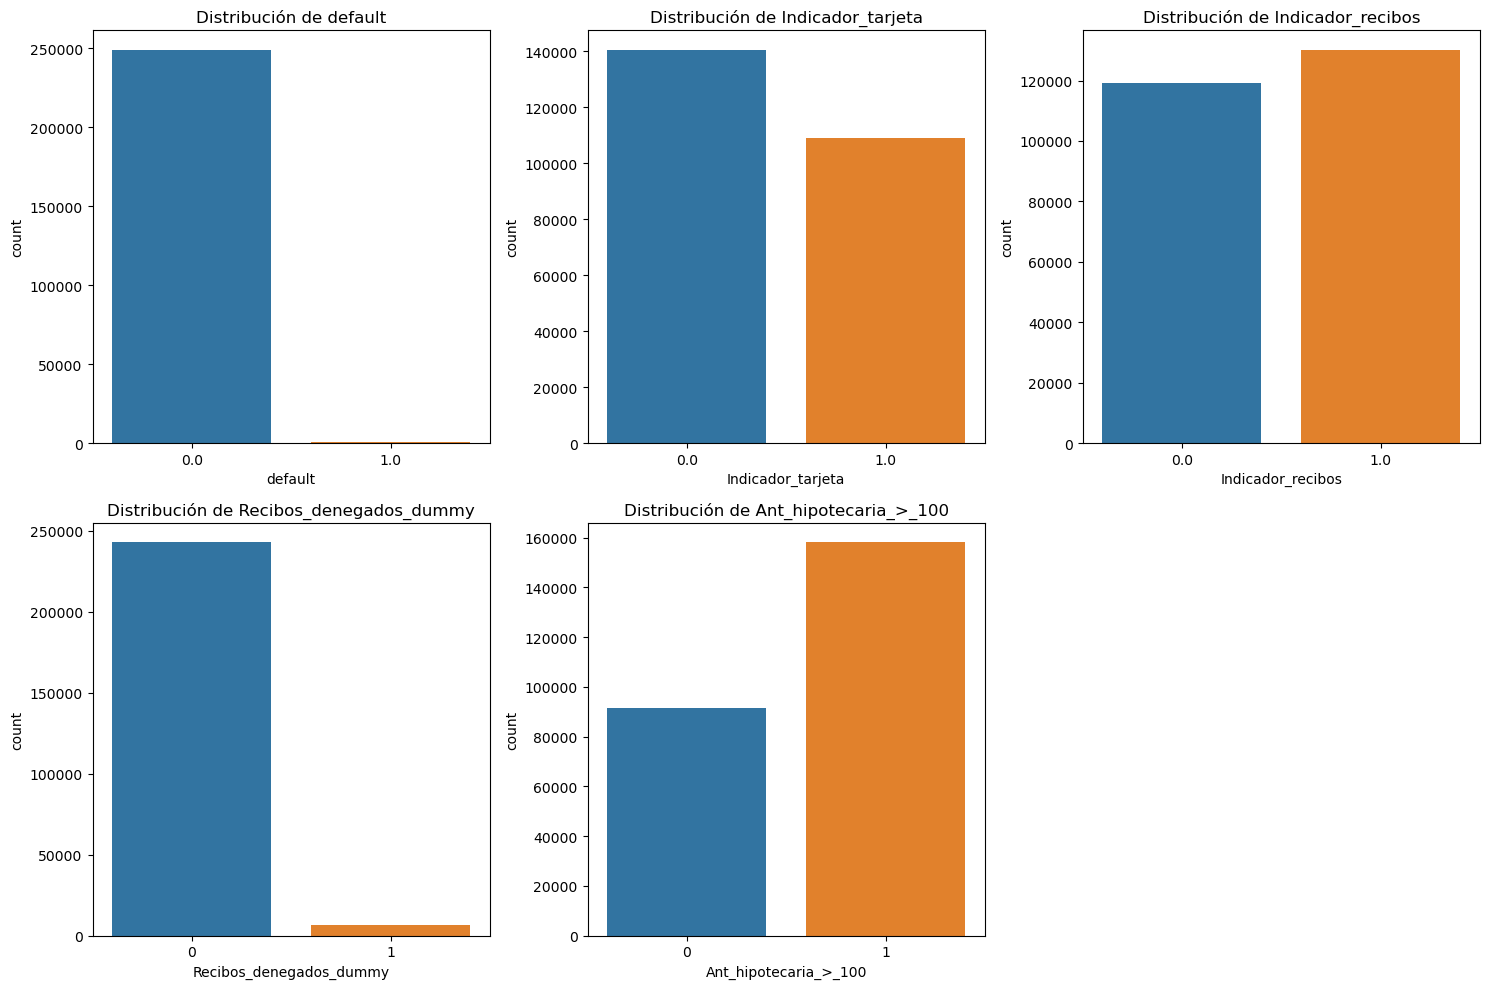

In [16]:
# Configuración de la cantidad de gráficos por fila
graficos_por_fila = 3

# Filtrar las columnas que tienen menos de 10 categorías
variables_para_graficar = [col for col in variables_categoricas if len(frecuencias_categoricas[col]) <= 10]

# Número total de filas necesarias
filas = math.ceil(len(variables_para_graficar) / graficos_por_fila)

# Crear los subplots
fig, axes = plt.subplots(filas, graficos_por_fila, figsize=(5 * graficos_por_fila, 5 * filas))

# Asegurarse de que `axes` es un arreglo bidimensional
axes = axes.reshape(-1, graficos_por_fila)

# Iterar sobre las variables y graficar
for idx, col in enumerate(variables_para_graficar):
    fila, col_fila = divmod(idx, graficos_por_fila)
    ax = axes[fila, col_fila]
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(f'Distribución de {col}')

# Eliminar subplots vacíos si el número de gráficos no es múltiplo de `graficos_por_fila`
for idx in range(len(variables_para_graficar), filas * graficos_por_fila):
    fila, col_fila = divmod(idx, graficos_por_fila)
    fig.delaxes(axes[fila, col_fila])

plt.tight_layout()
plt.show()

**2. Análisis de Variables Continuas**

In [17]:
# Extraer variables continuas
variables_continuas = df.select_dtypes(include=['int', 'float']).columns
len(variables_continuas)

52

**Visualización de la Distribución de Variables Continuas**

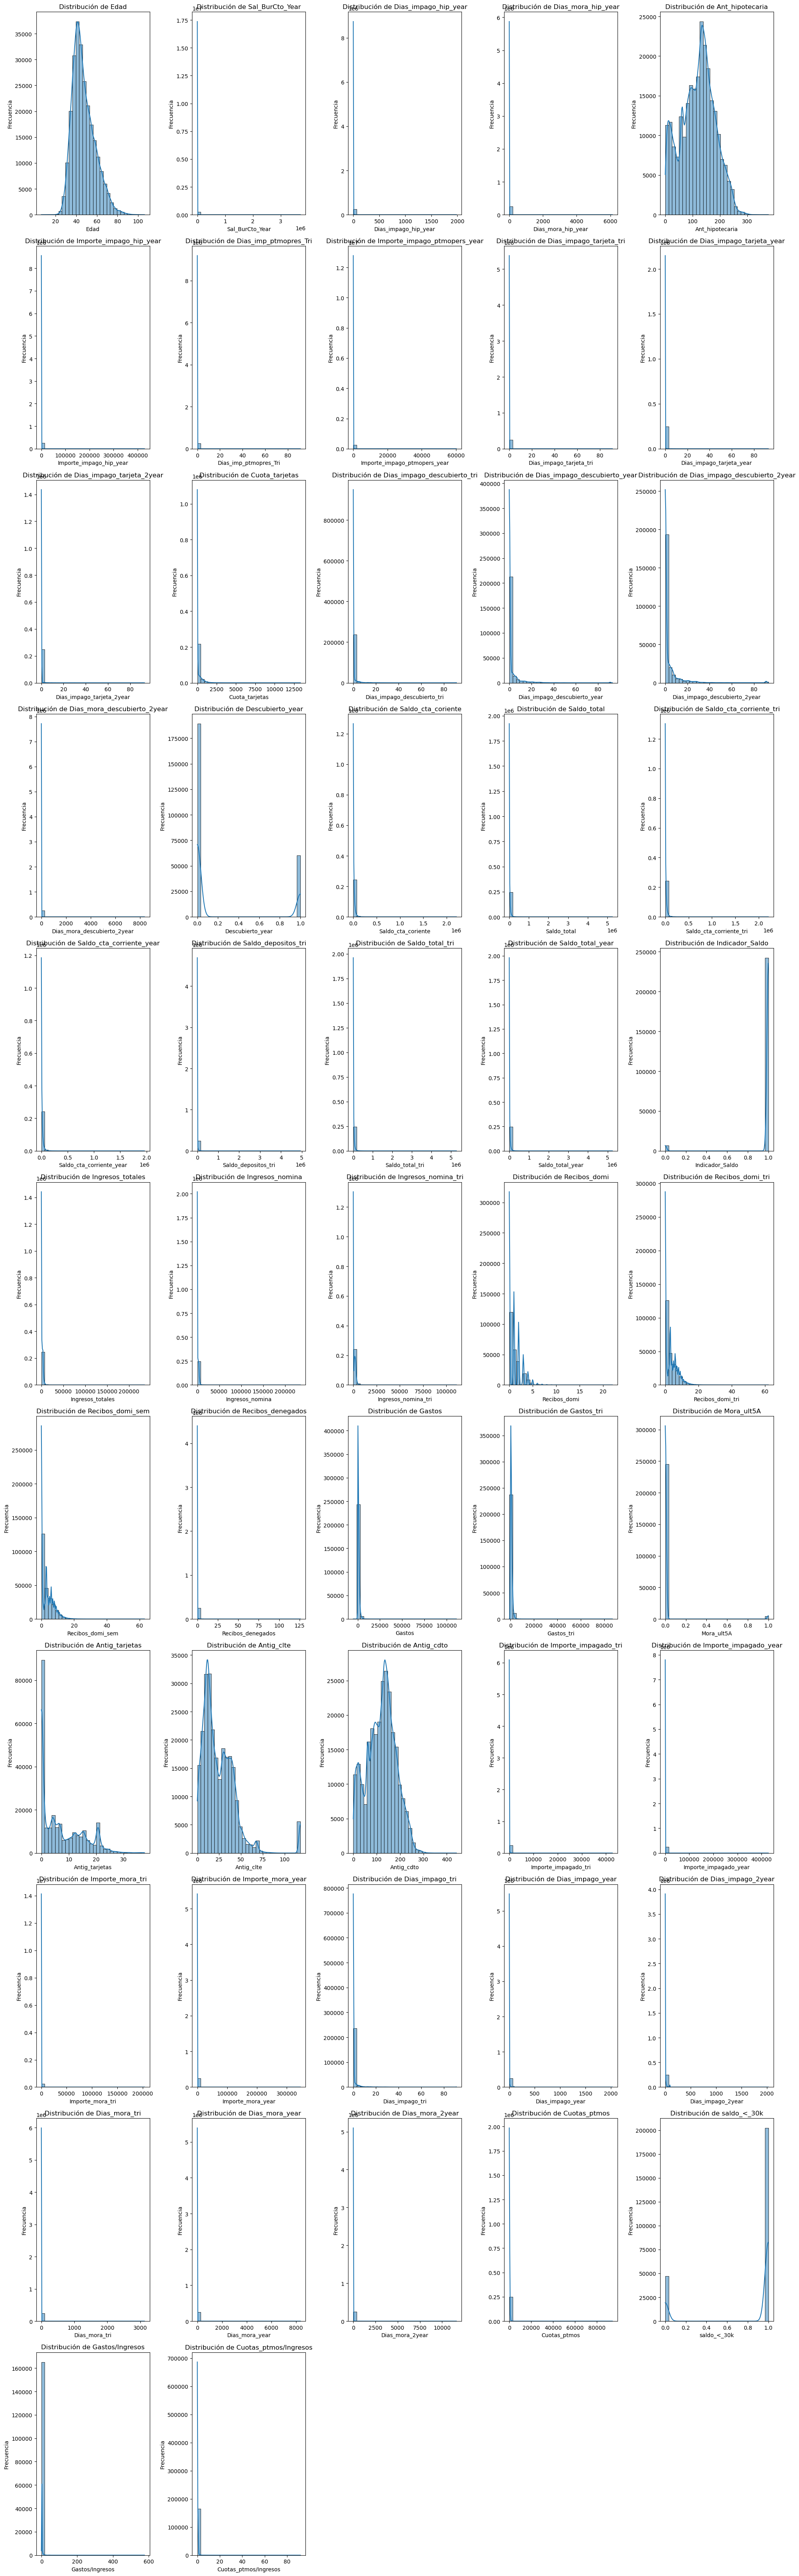

In [18]:
# Estadísticos descriptivos de las variables continuas
variables_continuas = df.select_dtypes(include=['int', 'float']).columns

# Número de filas y columnas para la cuadrícula
n_cols = 5
n_rows = (len(variables_continuas) // n_cols) + (len(variables_continuas) % n_cols > 0)

# Crear la figura y los subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))

# Aplanar la matriz de ejes para facilitar el acceso
axes = axes.flatten()

# Crear los histogramas
for i, var in enumerate(variables_continuas):
    sns.histplot(df[var], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')

# Eliminar los ejes adicionales si hay menos variables que subgráficos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el layout para evitar solapamientos
plt.tight_layout()
plt.show()

**Detección de Valores Atípicos (Outliers)**

In [19]:
# Detección de outliers mediante IQR
def detectar_outliers(df, variable):
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return df[(df[variable] < limite_inferior) | (df[variable] > limite_superior)]

# # Número de filas y columnas para la cuadrícula
# n_cols = 5
# n_rows = (len(variables_continuas) // n_cols) + (len(variables_continuas) % n_cols > 0)

# # Crear la figura y los subgráficos
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))

# # Aplanar la matriz de ejes para facilitar el acceso
# axes = axes.flatten()

# Mostrar outliers y boxplots por cada variable continua
for i, var in enumerate(variables_continuas):
    outliers = detectar_outliers(df, var)
    print(f'Outliers en {var}:', outliers.shape[0])
#     sns.boxplot(data=df, x=var, ax=axes[i])
#     axes[i].set_title(f'Boxplot de {var}')
#     axes[i].set_xlabel(var)

# # Eliminar los ejes adicionales si hay menos variables que subgráficos
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# # Ajustar el layout para evitar solapamientos
# plt.tight_layout()
# plt.show()

Outliers en Edad: 3607
Outliers en Sal_BurCto_Year: 6512
Outliers en Dias_impago_hip_year: 22830
Outliers en Dias_mora_hip_year: 382
Outliers en Ant_hipotecaria: 199
Outliers en Importe_impago_hip_year: 22715
Outliers en Dias_imp_ptmopres_Tri: 80
Outliers en Importe_impago_ptmopers_year: 596
Outliers en Dias_impago_tarjeta_tri: 617
Outliers en Dias_impago_tarjeta_year: 2698
Outliers en Dias_impago_tarjeta_2year: 4592
Outliers en Cuota_tarjetas: 47303
Outliers en Dias_impago_descubierto_tri: 24021
Outliers en Dias_impago_descubierto_year: 60129
Outliers en Dias_impago_descubierto_2year: 30732
Outliers en Dias_mora_descubierto_2year: 618
Outliers en Descubierto_year: 60129
Outliers en Saldo_cta_coriente: 23387
Outliers en Saldo_total: 24795
Outliers en Saldo_cta_corriente_tri: 23104
Outliers en Saldo_cta_corriente_year: 22635
Outliers en Saldo_depositos_tri: 45285
Outliers en Saldo_total_tri: 24640
Outliers en Saldo_total_year: 24681
Outliers en Indicador_Saldo: 6942
Outliers en Ingresos

**Test T**

In [ ]:
# Lista para almacenar las variables significativas
variables_significativas = []

# Realizar el Test T para cada variable continua
for var in variables_continuas:
    # Filtrar los datos por las dos categorías de 'default'
    group_0 = df[df['default'] == 0][var]
    group_1 = df[df['default'] == 1][var]
    
    # Realizar el test T de Student
    t_stat, p_value = ttest_ind(group_0, group_1, nan_policy='omit')
    
    # Mostrar los resultados
    print(f"Test T para {var}:")
    print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")
    
    # Si el valor p es menor a 0.05, se considera que hay una diferencia significativa
    if p_value < 0.05:
        print("Conclusión: Existen diferencias significativas entre las medias de las dos categorías.\n")
        variables_significativas.append(var)  # Almacenar la variable significativa
    else:
        print("Conclusión: No hay diferencias significativas entre las medias de las dos categorías.\n")

# Mostrar las variables significativas
print("Variables con diferencias significativas:")
print(variables_significativas)

# En resumen:

# Si el valor p es menor que 0.05, se considera que hay una diferencia significativa.
# Si el valor p es mayor que 0.05, no hay evidencia suficiente para afirmar que las medias sean diferentes, por lo que no se considera significativa.
# Por lo tanto, el criterio de selección es: quedarse con las variables cuyo valor p sea menor que 0.05.

Test T para Edad:
T-statistic: -5.558, P-value: 0.000
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Sal_BurCto_Year:
T-statistic: -2.464, P-value: 0.014
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Dias_impago_hip_year:
T-statistic: -42.270, P-value: 0.000
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Dias_mora_hip_year:
T-statistic: -17.155, P-value: 0.000
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Ant_hipotecaria:
T-statistic: -2.474, P-value: 0.013
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Importe_impago_hip_year:
T-statistic: -4.440, P-value: 0.000
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Dias_imp_ptmopres_Tri:
T-statistic: 0.219, P-value: 0.826
Concl

**Análisis Bivariante**

**Correlación de todas las variables**

In [ ]:
# Correlación entre variables --> TODAS

df['default'] = pd.to_numeric(df['default'], errors='coerce')

# Umbral de correlación
umbral = 0.7  # Puedes ajustar este valor según lo que consideres relevante

# Calcular la matriz de correlaciones
corr_matrix = df.corr()

# Enmascarar la diagonal (correlaciones de una variable consigo misma)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Filtrar las correlaciones por el umbral (superior a +0.7 o -0.7)
filtered_corr_matrix = corr_matrix.where(np.abs(corr_matrix) > umbral)

# Eliminar la diagonal (correlaciones de una variable consigo misma) para que no se muestre
filtered_corr_matrix = filtered_corr_matrix.stack().reset_index()

# Filtrar para que solo se muestren las correlaciones por encima del umbral (sin duplicados)
filtered_corr_matrix.columns = ['Variable_1', 'Variable_2', 'Correlacion']
filtered_corr_matrix = filtered_corr_matrix[filtered_corr_matrix['Variable_1'] != filtered_corr_matrix['Variable_2']]

# Mostrar la tabla
pd.set_option('display.max_rows', None)  # Para que muestre todas las filas sin truncarlas
filtered_corr_matrix.sort_values(by='Correlacion', ascending=False).reset_index(drop=True).head(10)

,Variable_1,Variable_2,Correlacion
0,Saldo_total,Saldo_total_tri,0.994641
1,Saldo_total_tri,Saldo_total,0.994641
2,Antig_cdto,Ant_hipotecaria,0.993897
3,Ant_hipotecaria,Antig_cdto,0.993897
4,Importe_impago_hip_year,Importe_impagado_year,0.989843
5,Importe_impagado_year,Importe_impago_hip_year,0.989843
6,Saldo_cta_corriente_tri,Saldo_cta_coriente,0.984173
7,Saldo_cta_coriente,Saldo_cta_corriente_tri,0.984173
8,Saldo_total_year,Saldo_total_tri,0.982182
9,Saldo_total_tri,Saldo_total_year,0.982182


**Correlación con respecto a la variable 'default'**

In [ ]:
# Obtener las correlaciones con 'default' de la matriz de correlación --> CORRELACIONES 'DEFAULT'

default_corr = corr_matrix['default'].sort_values(ascending=False)

# Mostrar las correlaciones con 'default', excluyendo la diagonal (correlación de 'default' consigo mismo)
default_corr = default_corr[default_corr.index != 'default']

# Mostrar los resultados
default_corr.head(10)

Dias_impago_descubierto_year     0.124999
Dias_impago_descubierto_2year    0.119540
Dias_impago_tri                  0.115121
Dias_impago_2year                0.112001
Dias_impago_year                 0.109373
Dias_impago_descubierto_tri      0.102896
Dias_impago_hip_year             0.084334
Mora_ult5A                       0.079127
Dias_mora_2year                  0.043143
Dias_impago_tarjeta_tri          0.040390
Name: default, dtype: float64

**Correlación con las variables consideradas de interés**

In [ ]:
#  Correlación con las variables de interés (están puestas en el doc, pq son de interés)

# Lista de variables de interés
variables_interes = [
    'default', 'Edad', 'Dias_impago_hip_year', 'Dias_mora_hip_year',
    'Dias_impago_descubierto_year', 'Saldo_total',
    'Saldo_cta_corriente_year', 'Ingresos_totales', 'Gastos', 'Mora_ult5A'
]

# Filtrar el dataset solo con las variables de interés
df_filtered = df[variables_interes]

# Calcular la matriz de correlación
correlation_matrix = df_filtered.corr()

# Umbral de correlación
umbral = 0.1  # Puedes ajustar este valor según lo que consideres relevante


# Enmascarar la diagonal (correlaciones de una variable consigo misma)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Filtrar las correlaciones por el umbral (superior a +0.7 o -0.7)
filtered_corr_matrix2 = correlation_matrix.where(np.abs(correlation_matrix) > umbral)

# Eliminar la diagonal (correlaciones de una variable consigo misma) para que no se muestre
filtered_corr_matrix2 = filtered_corr_matrix2.stack().reset_index()

# Filtrar para que solo se muestren las correlaciones por encima del umbral (sin duplicados)
filtered_corr_matrix2.columns = ['Variable_1', 'Variable_2', 'Correlacion']
filtered_corr_matrix2 = filtered_corr_matrix2[filtered_corr_matrix2['Variable_1'] != filtered_corr_matrix2['Variable_2']]

# Mostrar la tabla
pd.set_option('display.max_rows', None)  # Para que muestre todas las filas sin truncarlas
filtered_corr_matrix2.sort_values(by='Correlacion', ascending=False).reset_index(drop=True).head(10)

,Variable_1,Variable_2,Correlacion
0,Saldo_cta_corriente_year,Saldo_total,0.684352
1,Saldo_total,Saldo_cta_corriente_year,0.684352
2,Dias_impago_hip_year,Dias_impago_descubierto_year,0.323623
3,Dias_impago_descubierto_year,Dias_impago_hip_year,0.323623
4,Ingresos_totales,Gastos,0.276847
5,Gastos,Ingresos_totales,0.276847
6,Dias_impago_descubierto_year,Mora_ult5A,0.272732
7,Mora_ult5A,Dias_impago_descubierto_year,0.272732
8,Dias_impago_hip_year,Dias_mora_hip_year,0.255230
9,Dias_mora_hip_year,Dias_impago_hip_year,0.255230


**1. PARETO**

C:\Users\ntmsi\AppData\Local\Temp\ipykernel_12776\2814684371.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Variable', y='Importancia', data=pareto_df, palette='coolwarm')


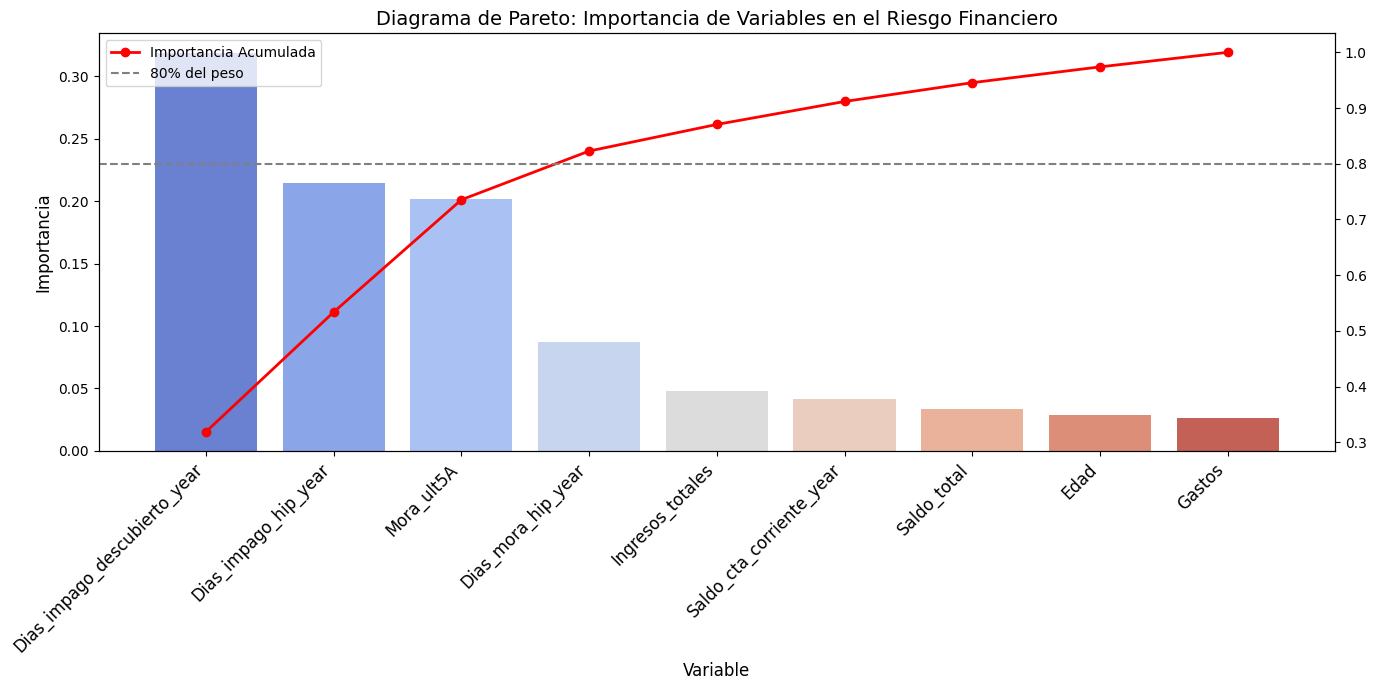

In [ ]:
# Filtrar variables predictoras
variables = [var for var in variables_interes if var != 'default']

# Calcular importancia
importances = []
for var in variables:
    if is_numeric_dtype(df[var]):  # Variables continuas
        correlation = abs(df[var].corr(df['default']))
    else:  # Variables categóricas
        mutual_info = mutual_info_classif(df[[var]], df['default'], discrete_features=True)
        correlation = mutual_info[0]  # Información mutua para esta variable
    importances.append((var, correlation))

# Normalizar importancias
importances = [(var, imp / sum(imp for _, imp in importances)) for var, imp in importances]

# Ordenar y convertir a DataFrame
importances = sorted(importances, key=lambda x: x[1], reverse=True)
pareto_df = pd.DataFrame(importances, columns=['Variable', 'Importancia'])
pareto_df['Importancia_Acumulada'] = pareto_df['Importancia'].cumsum()

# Graficar
plt.figure(figsize=(14, 7))
sns.barplot(x='Variable', y='Importancia', data=pareto_df, palette='coolwarm')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylabel('Importancia', fontsize=12)
plt.xlabel('Variable', fontsize=12)
plt.title('Diagrama de Pareto: Importancia de Variables en el Riesgo Financiero', fontsize=14)
plt.twinx()
plt.plot(pareto_df['Importancia_Acumulada'], color='r', marker='o', linewidth=2, label='Importancia Acumulada')
plt.axhline(0.8, color='gray', linestyle='--', label='80% del peso')
plt.legend(fontsize=10, loc='upper left')
plt.tight_layout()
plt.show()


**2. CORRELACIONES SPEARMAN / PEARSON**

Correlaciones significativas con 'default':
default                          1.000000
Dias_impago_descubierto_year     0.124999
Dias_impago_descubierto_2year    0.119540
Dias_impago_tri                  0.115121
Dias_impago_2year                0.112001
Dias_impago_year                 0.109373
Dias_impago_descubierto_tri      0.102896
Name: default, dtype: float64


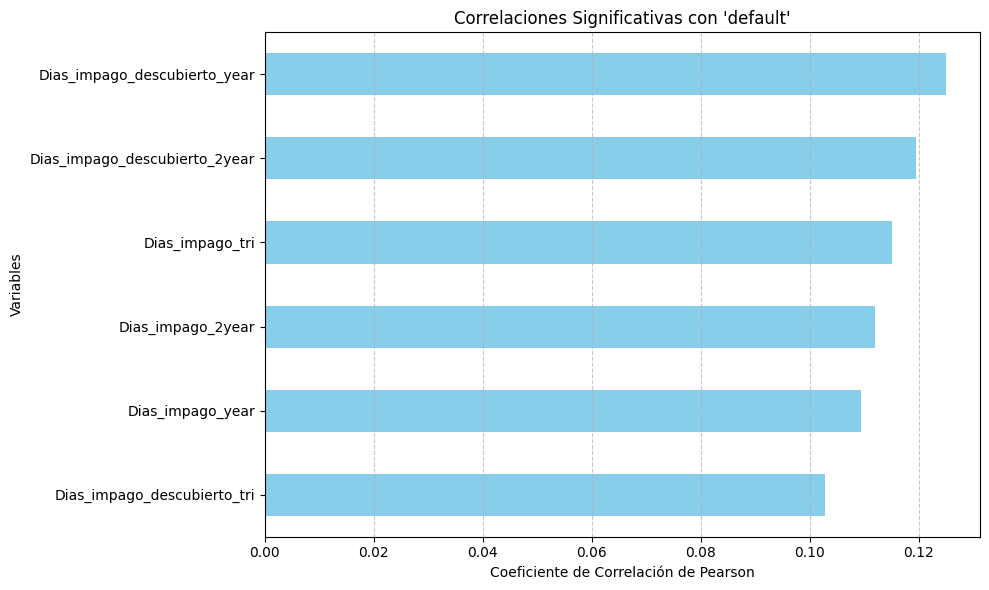

In [ ]:
# Convertir la columna 'default' a tipo numérico para calcular la correlación
df['default'] = pd.to_numeric(df['default'], errors='coerce')

# Seleccionar solo las variables continuas y la columna 'default'
variables_continuas = df.select_dtypes(include=['int', 'float']).columns.tolist()
if 'default' not in variables_continuas:
    variables_continuas.append('default')

# Calcular la matriz de correlación
correlation_matrix = df[variables_continuas].corr(method='pearson')

# Obtener las correlaciones con respecto a 'default'
correlaciones_default = correlation_matrix['default'].sort_values(ascending=False)

# Filtrar correlaciones significativas (por ejemplo, mayor a 0.1 o menor a -0.1)
umbral = 0.1  # Ajusta el umbral según sea necesario
correlaciones_significativas = correlaciones_default[abs(correlaciones_default) > umbral]

# Mostrar las correlaciones significativas
print("Correlaciones significativas con 'default':")
print(correlaciones_significativas)

# Graficar las correlaciones significativas
plt.figure(figsize=(10, 6))
correlaciones_significativas.drop('default').sort_values().plot(kind='barh', color='skyblue')
plt.title("Correlaciones Significativas con 'default'")
plt.xlabel("Coeficiente de Correlación de Pearson")
plt.ylabel("Variables")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**3. CHI CUADRADO**

In [40]:
# Crear un diccionario para almacenar los resultados del test chi-cuadrado
chi2_results = {}

# Filtrar las variables categóricas para que no incluyan 'default' ni 'cliente'
variables_categoricas_filtradas = [col for col in variables_categoricas if col not in ['default', 'Cliente']]

# Calcular el chi-cuadrado para cada variable categórica
for col in variables_categoricas_filtradas:
    contingency_table = pd.crosstab(df[col], df['default'])
    chi2, p, _, _ = chi2_contingency(contingency_table, correction=False)
    chi2_results[col] = {'Chi2': chi2, 'p_value': p}

# Convertir los resultados en un DataFrame
chi2_df = pd.DataFrame.from_dict(chi2_results, orient='index')

# Ordenar el DataFrame por el valor de Chi-cuadrado (columna 'Chi2') en orden descendente
chi2_df = chi2_df.sort_values(by='Chi2', ascending=False)

# Mostrar los resultados
print("Resultados del test Chi-cuadrado:")
print(chi2_df)

Resultados del test Chi-cuadrado:
                               Chi2       p_value
Recibos_denegados_dummy  258.707930  3.282156e-58
Indicador_recibos        119.321915  8.904077e-28
Indicador_tarjeta         97.506506  5.367962e-23
Ant_hipotecaria_>_100     13.795366  2.038384e-04


Lo de Unaima

In [ ]:
df['Edad_round'] = df['Edad'].round()
df.groupby('Edad_round')['Saldo_total'].mean().plot()

### **2. Construcción del Modelo de Clasificación**

**Filtrar por columnas seleccionadas tras el análisis**

In [70]:
# Seleccionar las columnas de interés
columnas_interes = [
    'Dias_impago_descubierto_year',
    'Dias_impago_hip_year',
    'Indicador_recibos',
    'Indicador_tarjeta',
    'Mora_ult5A',
    'Recibos_denegados_dummy',
    'Edad',
    'Sal_BurCto_Year',
    'default'  # Variable objetivo
]

# Filtrar el dataset solo con las columnas de interés
df_filtered = df[columnas_interes]
df_filtered.dtypes

Dias_impago_descubierto_year    float64
Dias_impago_hip_year            float64
Indicador_recibos                object
Indicador_tarjeta                object
Mora_ult5A                      float64
Recibos_denegados_dummy          object
Edad                            float64
Sal_BurCto_Year                 float64
default                          object
dtype: object

**Balanceo y División en Train y Test**

In [64]:
# IMPLEMENTAR UNDERSAMPLING PARA QUE EL MODELO APRENDA SOBRE TODO DE LOS QUE HAN ENTRADO EN DEFAULT

# Definir las variables predictoras (X) y la variable objetivo (y)
X = df_filtered.drop('default', axis=1)  # Variables predictoras
y = df_filtered ['default']  # Variable objetivo (target)

# Dividir el dataset en conjunto de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train_og, X_test, y_train_og, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
y_train_og = y_train_og.astype(int)
y_test = y_test.astype(int)

# Crear una instancia del RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Aplicar el undersampling
X_train, y_train = undersampler.fit_resample(X_train_og, y_train_og)

# Ver la distribución de las clases después del undersampling
print("Distribución original en el conjunto de entrenamiento:")
print(y_train_og.value_counts())
print("\nDistribución después del undersampling:")
print(y_train.value_counts())

Distribución original en el conjunto de entrenamiento:
0    174331
1       272
Name: default, dtype: int64

Distribución después del undersampling:
0    272
1    272
Name: default, dtype: int64


**Modelo Regresión Logística**

In [66]:
# Instanciamos el modelo de regresión logística
log_reg_model = LogisticRegression(random_state=42)

# Entrenamos el modelo
log_reg_model.fit(X_train, y_train)

# Predicciones sobre el conjunto de validación
y_pred_prob = log_reg_model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
y_pred = log_reg_model.predict(X_test)  # Predicción final (clase 0 o 1)

c:\Users\Usuario\anaconda3\envs\DM_reto9\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


**Evaluación modelo**

**Curva ROC y AUC**

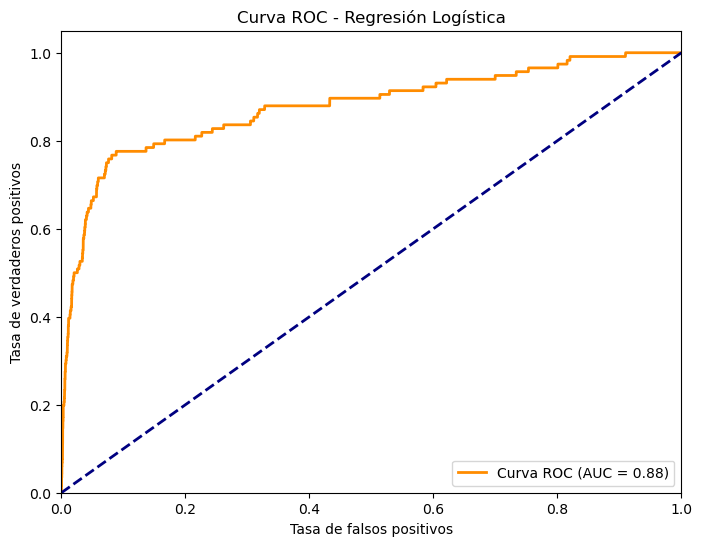

In [ ]:
# Cálculo de la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.show()

**Matriz de confusión**

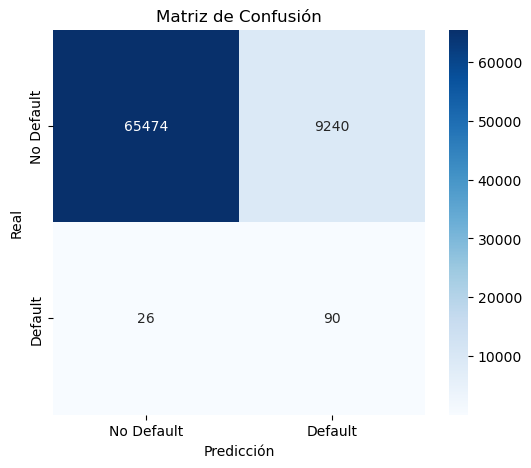

In [68]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


In [ ]:
# Calcular el accuracy
accuracy = accuracy_score(y_test, y_pred)

# Mostrar el resultado
print(f"Accuracy del modelo: {accuracy:.4f}")

Accuracy del modelo: 0.8762


**Importancia de las variables en el modelo**

In [74]:
# Obtenemos los coeficientes del modelo
coefficients = log_reg_model.coef_[0]  # Coeficientes de la clase positiva (log-odds)

# Convertimos a pesos relativos
importance_percentage = 100 * (np.abs(coefficients) / np.sum(np.abs(coefficients)))

# Crear un DataFrame para mostrar resultados
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature_{i}" for i in range(X_train.shape[1])]
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance (%)": importance_percentage
}).sort_values(by="Importance (%)", ascending=False)

# Mostrar resultados
print(importance_df)

                        Feature  Importance (%)
4                    Mora_ult5A       38.859551
5       Recibos_denegados_dummy       25.626576
2             Indicador_recibos       21.977025
3             Indicador_tarjeta       10.102279
0  Dias_impago_descubierto_year        1.726450
1          Dias_impago_hip_year        1.169104
6                          Edad        0.538919
7               Sal_BurCto_Year        0.000097


**Modelo Black box**

In [ ]:
# Instanciar el LabelEncoder
le = LabelEncoder()

# Convertir las columnas categóricas a valores numéricos
X_train['Indicador_recibos'] = le.fit_transform(X_train['Indicador_recibos'])
X_train['Indicador_tarjeta'] = le.fit_transform(X_train['Indicador_tarjeta'])
X_train['Recibos_denegados_dummy'] = le.fit_transform(X_train['Recibos_denegados_dummy'])

X_test['Indicador_recibos'] = le.transform(X_test['Indicador_recibos'])
X_test['Indicador_tarjeta'] = le.transform(X_test['Indicador_tarjeta'])
X_test['Recibos_denegados_dummy'] = le.transform(X_test['Recibos_denegados_dummy'])


In [81]:
# Convertir a DMatrix de XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definir los parámetros del modelo
params = {
    'objective': 'binary:logistic',  # Clasificación binaria
    'eval_metric': 'logloss',  # Métrica de evaluación (log-loss)
    'max_depth': 6,  # Profundidad máxima del árbol
    'eta': 0.1,  # Tasa de aprendizaje
    'subsample': 0.8,  # Submuestra de datos
    'colsample_bytree': 0.8  # Submuestra de columnas
}

# Entrenar el modelo
num_round = 100  # Número de rondas de boosting
model = xgb.train(params, dtrain, num_round)

# Predicciones sobre el conjunto de prueba
y_pred_prob = model.predict(dtest)  # Probabilidades de la clase positiva
y_pred = (y_pred_prob > 0.5).astype(int)  # Predicción final (clase 0 o 1)

**Evaluación modelo**

In [83]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
cm = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print('Matriz de confusión:')
print(cm)

Accuracy: 0.8424295068822665
ROC AUC: 0.8857833619328142
Matriz de confusión:
[[62945 11769]
 [   22    94]]


**Importancia de las variables en el modelo**

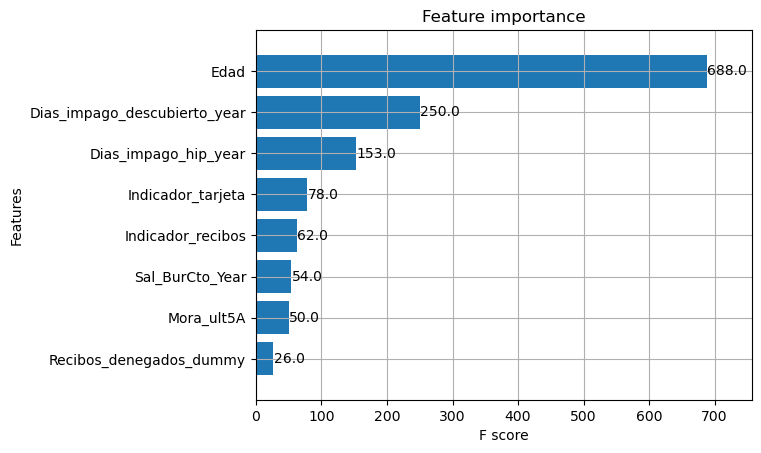

In [84]:
# Obtener la importancia de las características
xgb.plot_importance(model, importance_type='weight', max_num_features=10, height=0.8)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definir los parámetros para GridSearch
param_grid = {
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Crear el modelo XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Ejecutar GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_og, y_train_og)

# Mostrar los mejores parámetros
print('Mejores parámetros:', grid_search.best_params_)

# Usar el modelo con los mejores parámetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print(f'Accuracy con mejores parámetros: {accuracy}')
print(f'ROC AUC con mejores parámetros: {roc_auc}')

**Comparación**